In [19]:
# required libraries imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)

In [20]:
# given file path
case_data = r"E:\ml_nlp\git\lending_club_case_study\assets\loan.csv"
loan = pd.read_csv(case_data, low_memory=False)

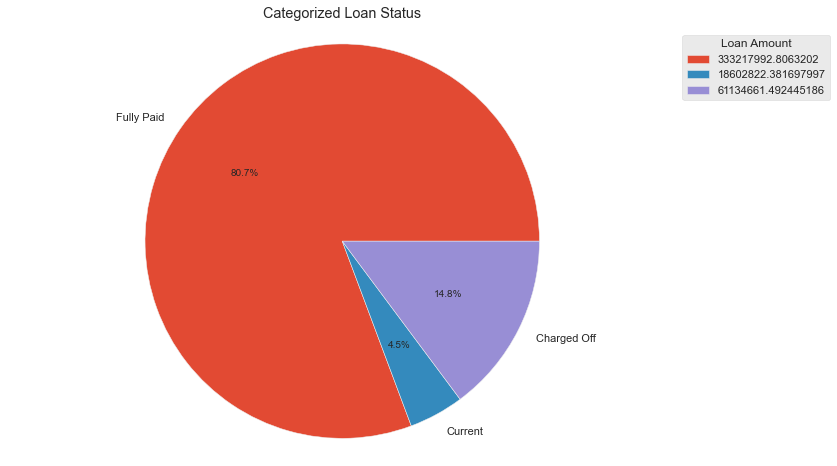

In [21]:
# categorizing different types of loan status with pie chart
fullyPaid = loan.loc[(loan["loan_status"] == "Fully Paid")]
current = loan.loc[(loan["loan_status"] == "Current")]
chargedOff = loan.loc[(loan["loan_status"] == "Charged Off")]

data = [{"Fully Paid":fullyPaid["funded_amnt_inv"].sum(), "Current":current["funded_amnt_inv"].sum(), "Charged Off":chargedOff["funded_amnt_inv"].sum()}]

inv_sum = pd.DataFrame(data)
sumOfFullyPaid = float(inv_sum["Fully Paid"])
sumOfCurrent = float(inv_sum["Current"])
sumOfChargedOff = float(inv_sum["Charged Off"])

loan_status = [sumOfFullyPaid,sumOfCurrent,sumOfChargedOff]
loan_status_label = 'Fully Paid','Current','Charged Off'
plt.pie(loan_status, labels=loan_status_label, autopct='%1.1f%%')
plt.title('Categorized Loan Status')
plt.axis('equal')
plt.legend(loan_status, title='Loan Amount', loc="center left", bbox_to_anchor=(1,0.4,0.5,1))
plt.show()

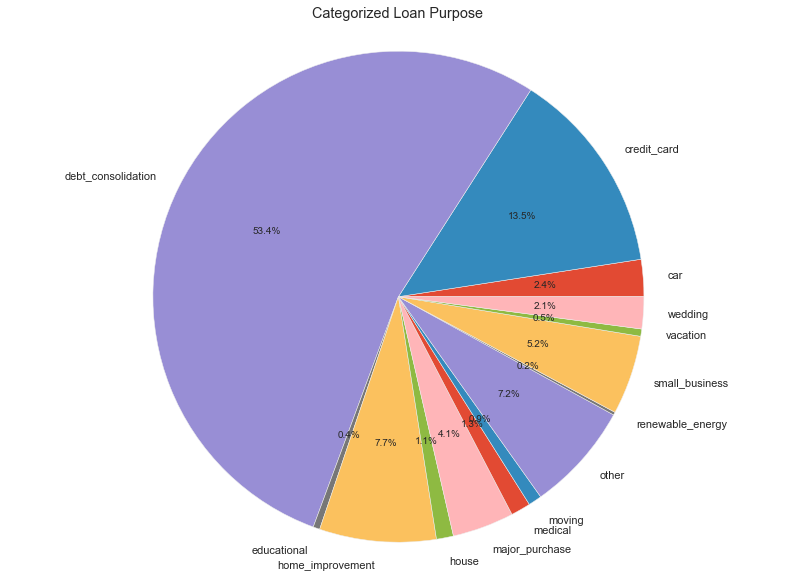

In [22]:
# categorizing types of purpose for loan with pie chart
loans_purpose = loan.groupby(['purpose'])['funded_amnt_inv'].sum().reset_index()

plt.figure(figsize=(14,10))
plt.pie(loans_purpose['funded_amnt_inv'], labels=loans_purpose['purpose'], autopct='%1.1f%%')

plt.title('Categorized Loan Purpose')
plt.axis('equal')
plt.show()


In [23]:
# The columns those are completely null are removed from dataset

loan = loan.dropna(axis=1, how='all')
print(loan.info(max_cols=120))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [24]:
# looking for the remaining columns there are still columns left those are not required
# removal non-required columns

columnsNotRequired = ["id","member_id","funded_amnt","emp_title","pymnt_plan","url","desc","title","zip_code", "addr_state", "delinq_2yrs","mths_since_last_delinq","mths_since_last_record","revol_bal","initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "pub_rec_bankruptcies", "tax_liens"]
loan.drop(columnsNotRequired, axis=1, inplace=True)
print(list(loan.columns))

['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']


In [25]:
# removing rows with missing values
# there are seen few null values in emp_length and revol_util

loan.dropna(axis=0, subset=["emp_length"], inplace=True)
loan.dropna(axis=0, subset=["revol_util"], inplace=True)

In [26]:
# updating int_rate and revol_util without percentage symbol

loan["int_rate"] = pd.to_numeric(loan["int_rate"].apply(lambda x:x.split('%')[0]))
loan["revol_util"] = pd.to_numeric(loan["revol_util"].apply(lambda x:x.split('%')[0]))

In [27]:
# removing text months from term columns

loan["term"] = pd.to_numeric(loan["term"].apply(lambda x:x.split()[0]))

In [28]:
# removing the rows with loan status as current
# because it is difficult to do further having current loan status

loan = loan[loan["loan_status"].apply(lambda x:False if x=="Current" else True)]

In [29]:
# distinguishing loan_status as 0 and 1 for fully paid and charged off respectively
# the distinguish is done for easiness of counting both the data

loan["loan_status"] = loan["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)

In [30]:
# managing date
def manage_date(date):
    year = date.split("-")[0]
    if(len(year)==1):
        date = "0"+date
    return date

from datetime import datetime
loan['issue_d'] = loan['issue_d'].apply(lambda x:manage_date(x))
loan['issue_d'] = loan['issue_d'].apply(lambda x:datetime.strptime(x, '%b-%y'))

# extracting month and year from datetime_issue

loan['month'] = loan['issue_d'].apply(lambda x: x.month)
loan['year'] = loan['issue_d'].apply(lambda x: x.year)

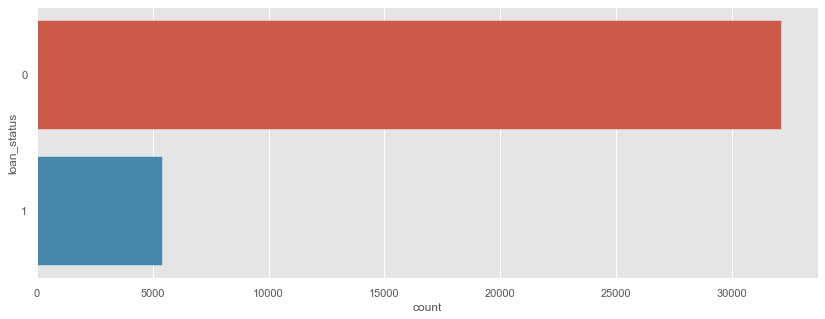

In [31]:
# status of no. of defaults and fully paid customers.
# Here 0 is fully paid and 1 is charged off/default category.

plt.figure(figsize=(14,5))
sns.countplot(y="loan_status", data=loan)
plt.show()

In [32]:
# univariate analysis setup as per ratio

def univariateRatioAnalysis(feature, data=loan, figsize=(12,8), rsorted=True):
    plt.figure(figsize=figsize)
    if rsorted:
        feature_dimension = sorted(data[feature].unique())
    else:
        feature_dimension = data[feature].unique()
    feature_values = []
    for fd in feature_dimension:
        feature_filter = data[data[feature]==fd]
        feature_count = len(feature_filter[feature_filter["loan_status"]==1])
        feature_values.append(feature_count*100/feature_filter["loan_status"].count())
    plt.bar(feature_dimension, feature_values, color='orange', edgecolor='white')
    plt.title("Defaulters on the basis of "+str(feature)+" - countplot")
    plt.xlabel(feature, fontsize=16)
    plt.ylabel("defaulter %", fontsize=16)
    plt.show()

# univariate analysis setup as per scale of 0-1

def univariateScaleAnalysis(x, figsize=(10,5)):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y='loan_status', data=loan)
    plt.title("Defaulters on the basis of "+str(x)+" - countplot")
    plt.xlabel(x, fontsize=16)
    plt.ylabel("defaulter ratio", fontsize=16)
    plt.show()


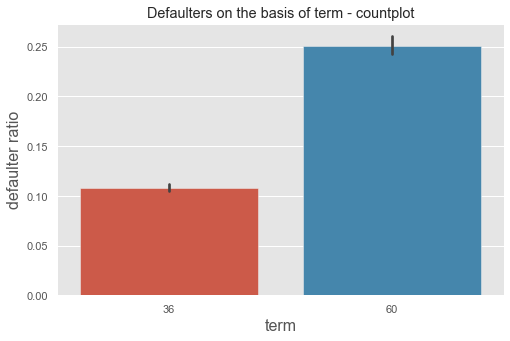

In [33]:
# univariate analysis on basis of "Charged Off" loan_status

# check defaulters on the basis of terms
univariateScaleAnalysis("term", figsize=(8,5))


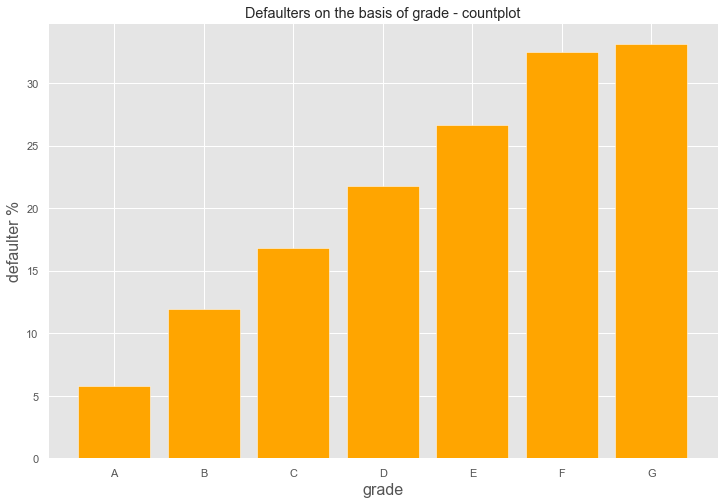

In [34]:
# check defaulters on the basis of grades

univariateRatioAnalysis("grade")

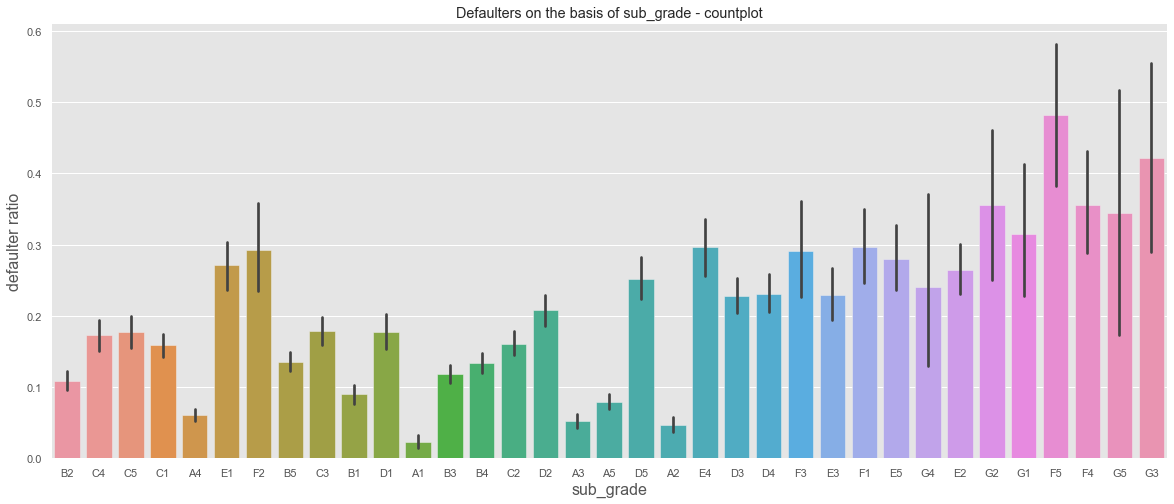

In [35]:
# check defaulters on the basis of sub_grades

univariateScaleAnalysis("sub_grade", figsize=(20,8))

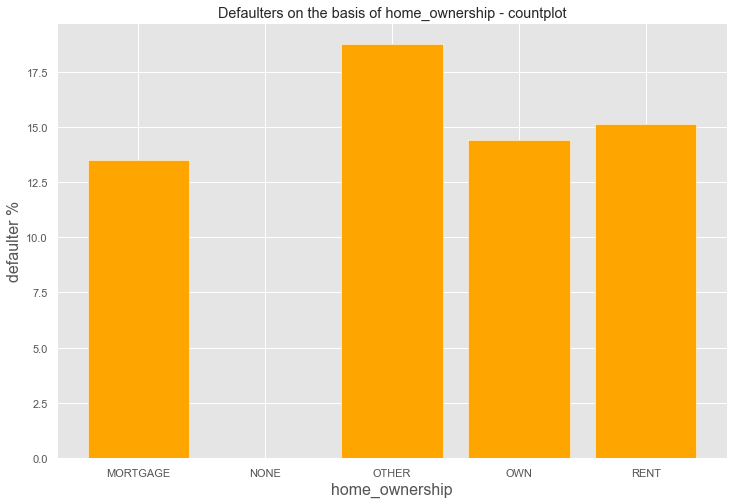

In [36]:
# check defaulters on the basis of home_ownership

univariateRatioAnalysis("home_ownership")

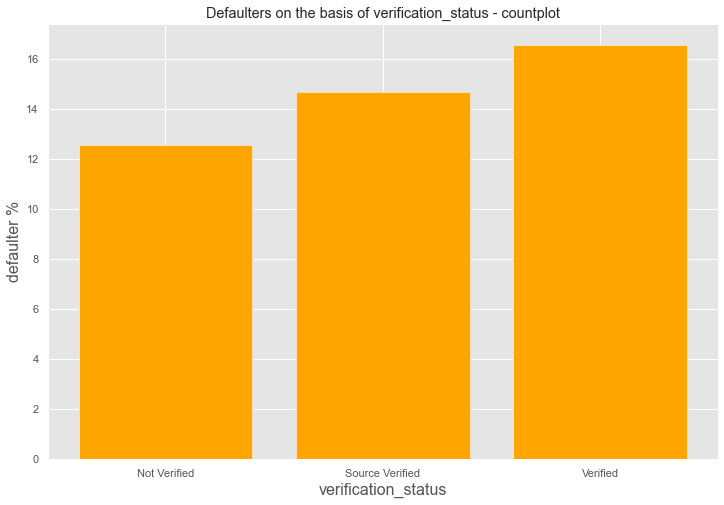

In [37]:
# check defaulters on the basis of verification_status

univariateRatioAnalysis("verification_status")

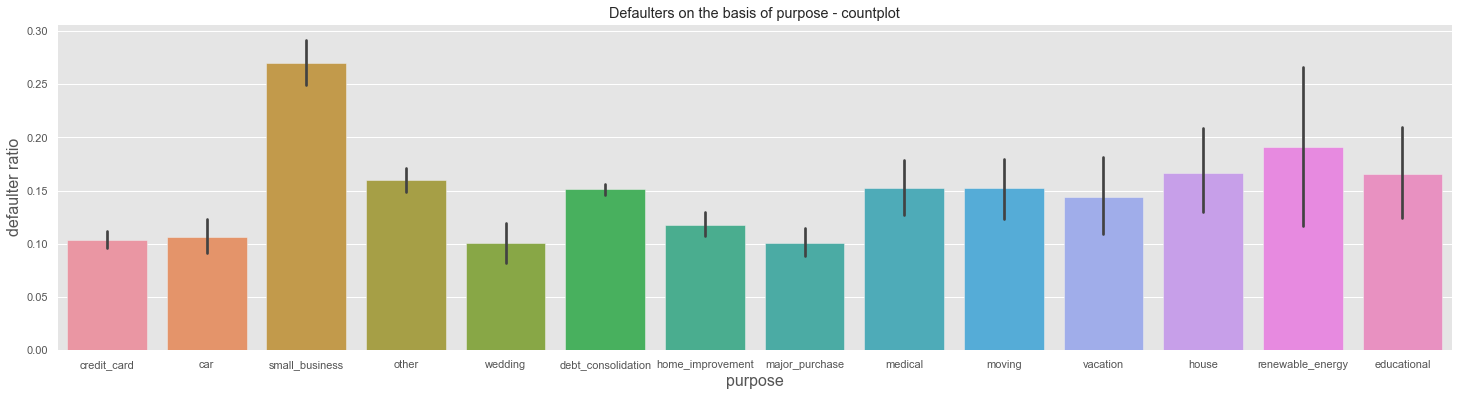

In [38]:
# check defaulters on the basis of purpose

univariateScaleAnalysis("purpose", figsize=(25,6))

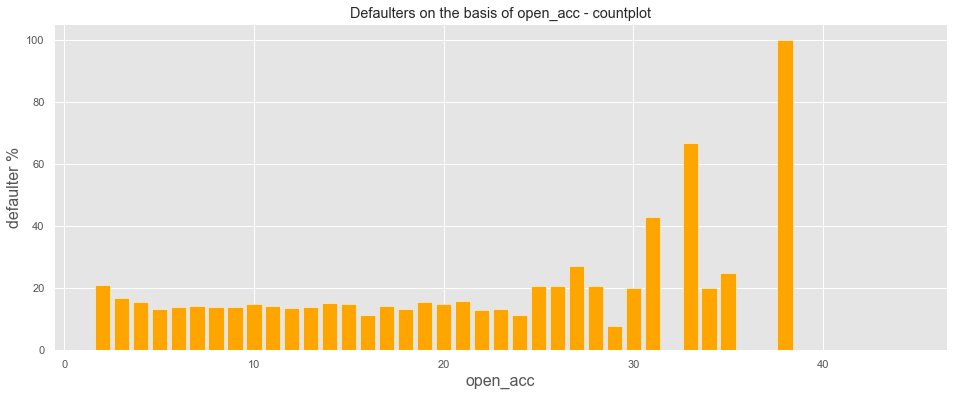

In [39]:
# check defaulters on the basis of open_acc

univariateRatioAnalysis("open_acc", figsize=(16,6))

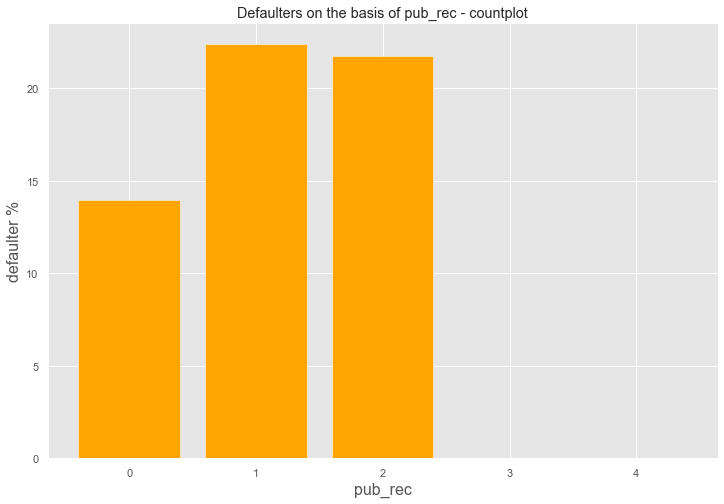

In [40]:
# check defaulters on the basis of pub_rec

univariateRatioAnalysis("pub_rec")

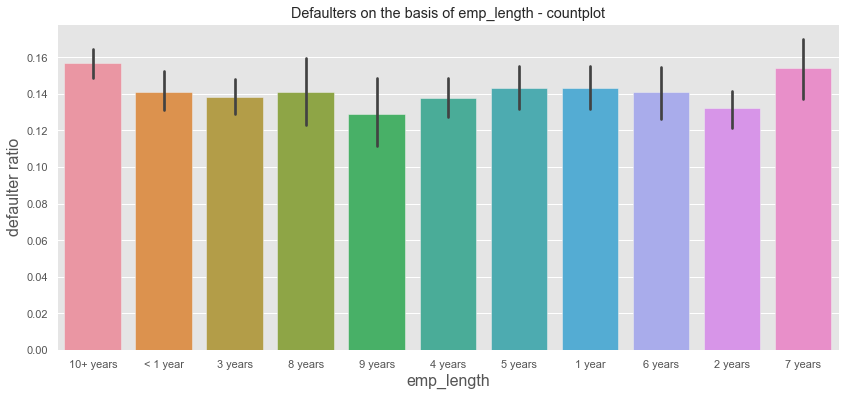

In [41]:
# check defaulters on the basis of emp_length

univariateScaleAnalysis("emp_length", figsize=(14,6))

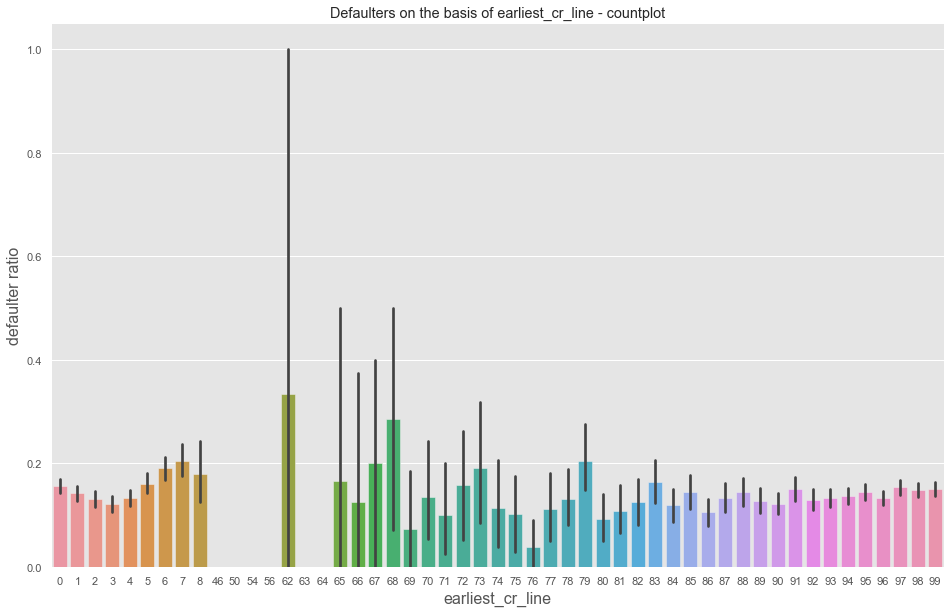

In [42]:
# get year datetime issue and replace it
loan["earliest_cr_line"] = pd.to_numeric(loan["earliest_cr_line"].apply(lambda x:x.split('-')[1]))

# check defaulters on the basis of earliest_cr_line

univariateScaleAnalysis("earliest_cr_line", figsize=(16,10))

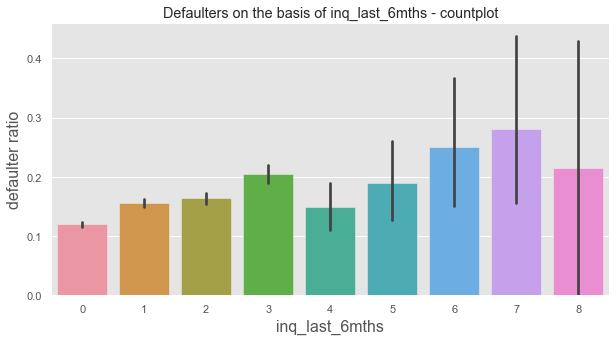

In [43]:
# check defaulters on the basis of inq_last_6mths

univariateScaleAnalysis("inq_last_6mths")

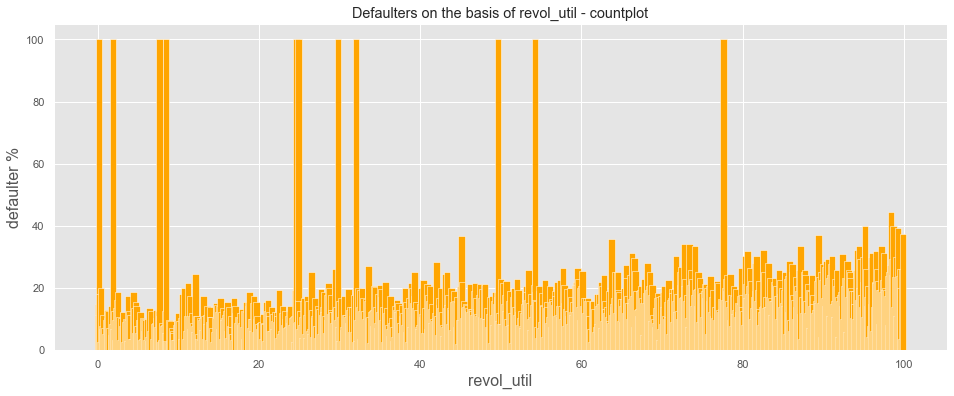

In [44]:
# check defaulters on the basis of revol_util

univariateRatioAnalysis("revol_util", figsize=(16,6))

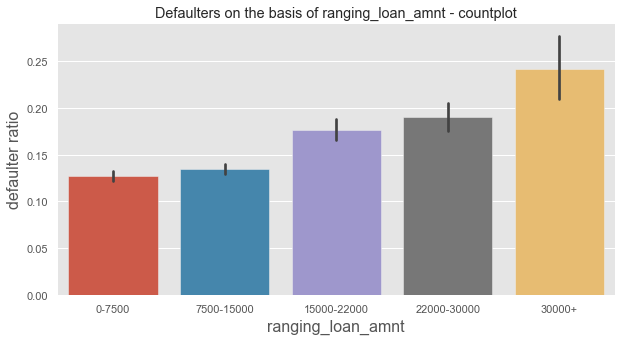

In [45]:
# ranging loan_amnt
round_offs = [0,7500,15000,22000,30000,40000]
ranging = ['0-7500', '7500-15000', '15000-22000','22000-30000','30000+']
loan['ranging_loan_amnt'] = pd.cut(loan['loan_amnt'], round_offs, labels=ranging)

# check defaulters on the basis of ranging_loan_amnt

univariateScaleAnalysis("ranging_loan_amnt")

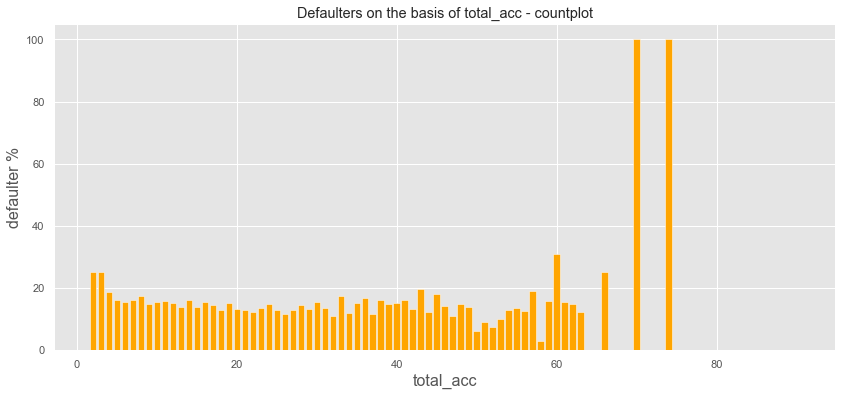

In [46]:
# check defaulters on the basis of total_acc

univariateRatioAnalysis("total_acc", figsize=(14,6))

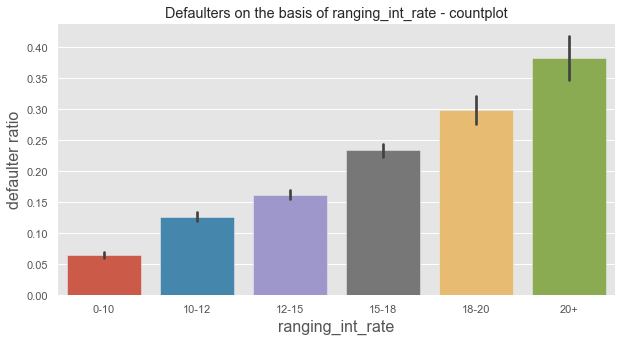

In [47]:
# ranging int_rate
round_offs = [0,10,12,15,18,20,50]
ranging = ['0-10','10-12','12-15','15-18','18-20','20+']
loan['ranging_int_rate'] = pd.cut(loan['int_rate'], round_offs, labels=ranging)

# check defaulters on the basis of ranging_int_rate
univariateScaleAnalysis("ranging_int_rate")

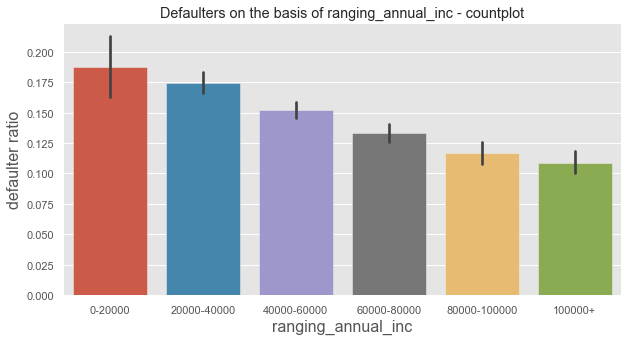

In [48]:
#ranging annual income
round_offs = [0,20000,40000,60000,80000,100000,200000]
ranging = ['0-20000','20000-40000','40000-60000','60000-80000','80000-100000','100000+']
loan['ranging_annual_inc'] = pd.cut(loan['annual_inc'], round_offs, labels=ranging)

# check defaulters on the basis of ranging_annual_inc

univariateScaleAnalysis("ranging_annual_inc")

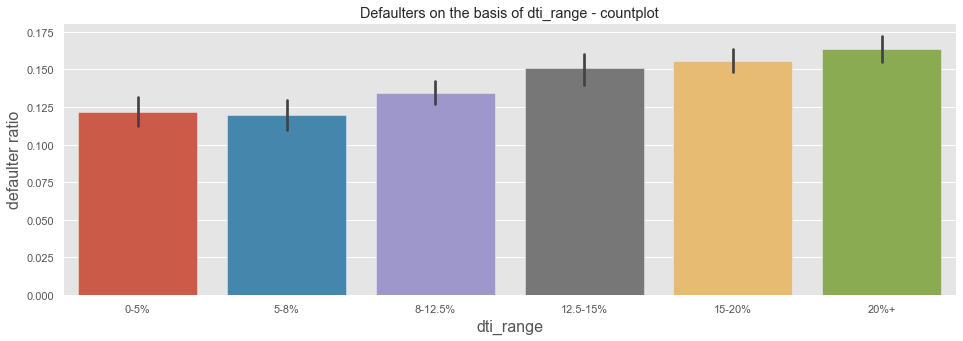

In [49]:
# ranging dti
round_offs = [0, 5.00, 8.00, 12.50, 15.00, 20.00, 50.00]
ranging = ['0-5%', '5-8%', '8-12.5%', '12.5-15%', '15-20%', '20%+']
loan['dti_range'] = pd.cut(loan['dti'], round_offs, labels=ranging)

# check defaulters on the basis of dti_range
univariateScaleAnalysis("dti_range", figsize=(16,5))

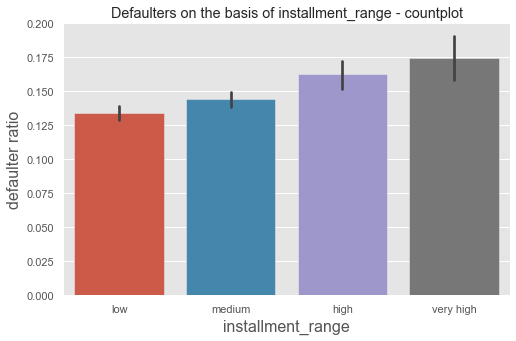

In [50]:
# setting up range for installment
def installment_range(n):
    if n<=250:
        return 'low'
    elif n>250 and n<=500:
        return 'medium'
    elif n>500 and n<=750:
        return 'high'
    else:
        return 'very high'

loan['installment_range'] = loan['installment'].apply(lambda x:installment_range(x))

# check defaulters on the basis of installment_range
univariateScaleAnalysis("installment_range", figsize=(8,5))

In [51]:
# Bivariate Analysis with help of Scatter plot and Bar plot
def plotScatter(x, y):
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, hue="loan_status", data=loan)
    plt.title("Scatter plot of Defaulters between "+x+" and "+y)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.show()
    
def plotBarBivariateAnalysis(x, hue, figsize=(16,6)):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y='loan_status', hue=hue, data=loan)
    plt.title("Defaulters on the basis of "+x+" and "+hue+" - countplot")
    plt.xlabel(x, fontsize=20)
    plt.ylabel("defaulter ratio", fontsize=20)
    plt.show()

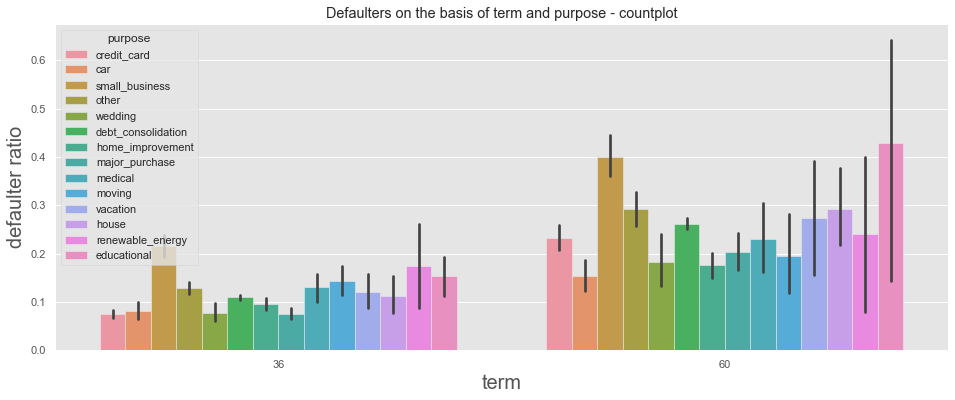

In [52]:
# check defaulters on the basis of term and purpose

plotBarBivariateAnalysis("term", "purpose")


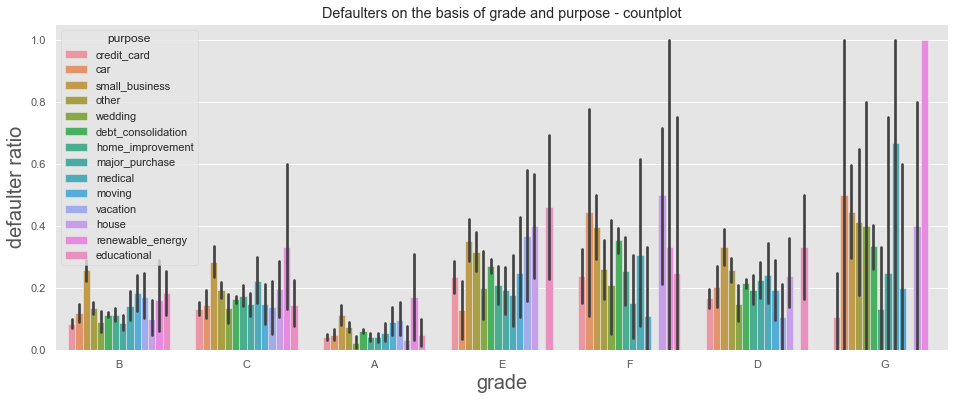

In [53]:
# check defaulters on the basis of grade and purpose

plotBarBivariateAnalysis("grade", "purpose")


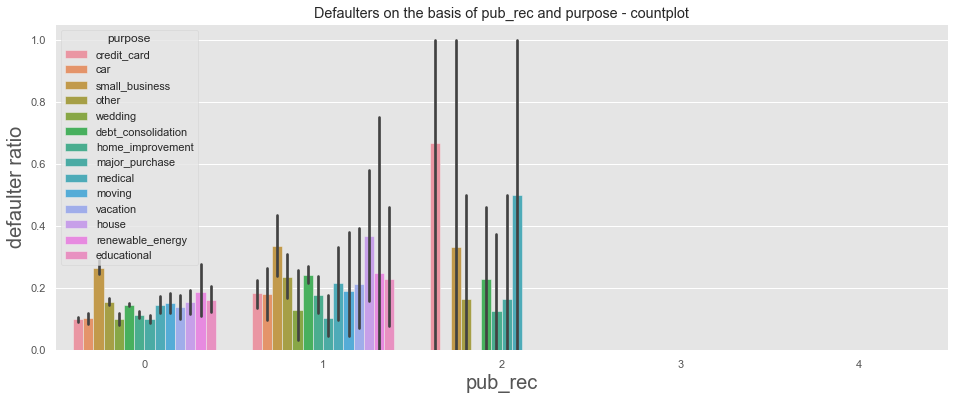

In [54]:
# check defaulters on the basis of pub_rec and purpose

plotBarBivariateAnalysis("pub_rec", "purpose")


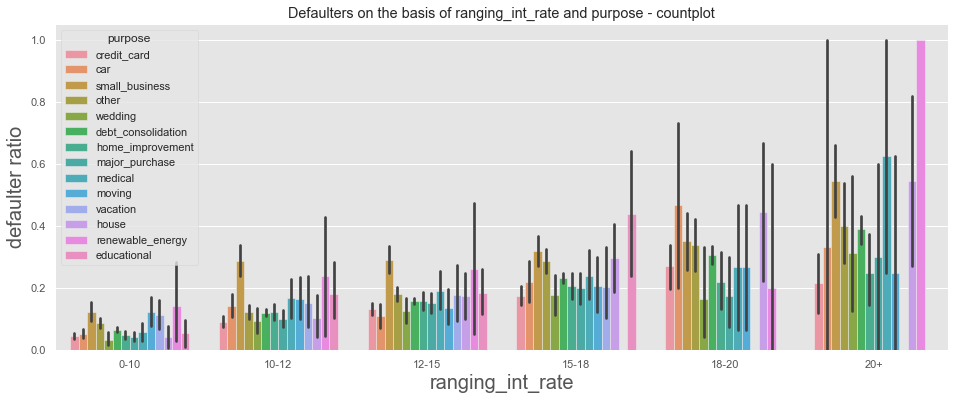

In [55]:
# check defaulters on the basis of int_rate and purpose

plotBarBivariateAnalysis("ranging_int_rate", "purpose")

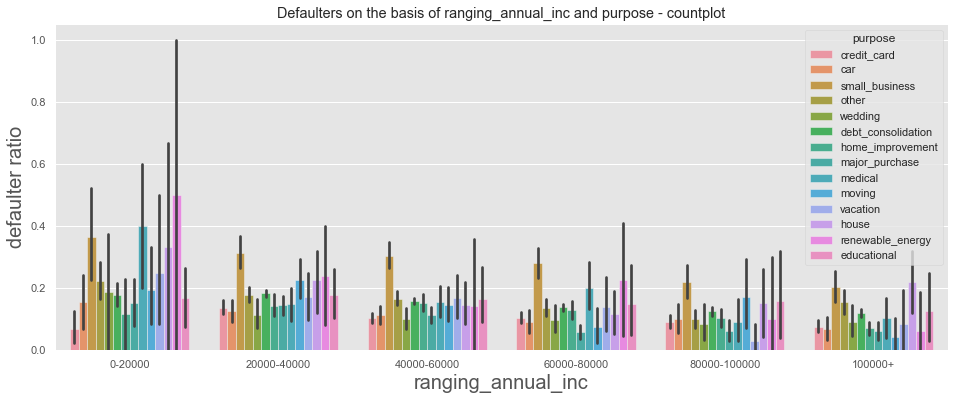

In [56]:
# check defaulters on the basis of annual_inc and purpose

plotBarBivariateAnalysis("ranging_annual_inc", "purpose")


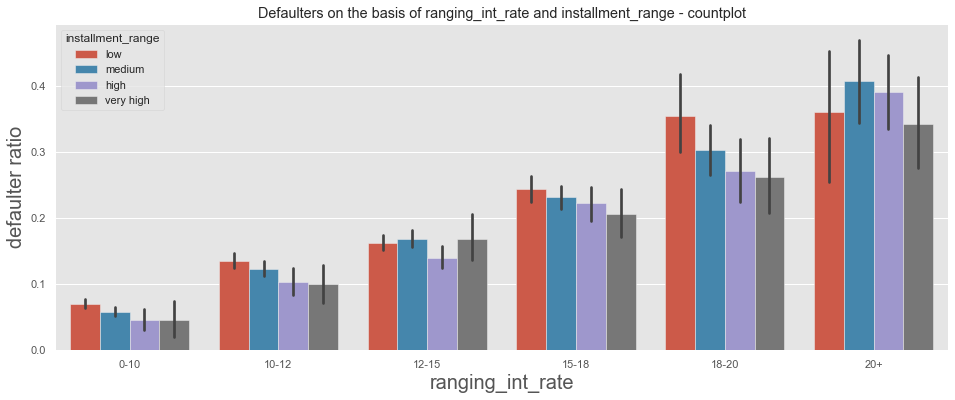

In [57]:
# check defaulters on the basis of int_rate and installment

plotBarBivariateAnalysis("ranging_int_rate", "installment_range")

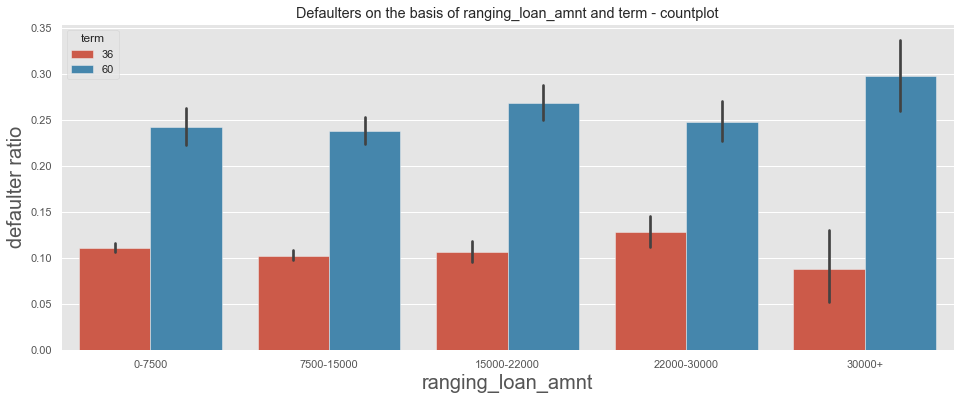

In [58]:
# check defaulters on the basis of loan_amnt and term

plotBarBivariateAnalysis("ranging_loan_amnt", "term")

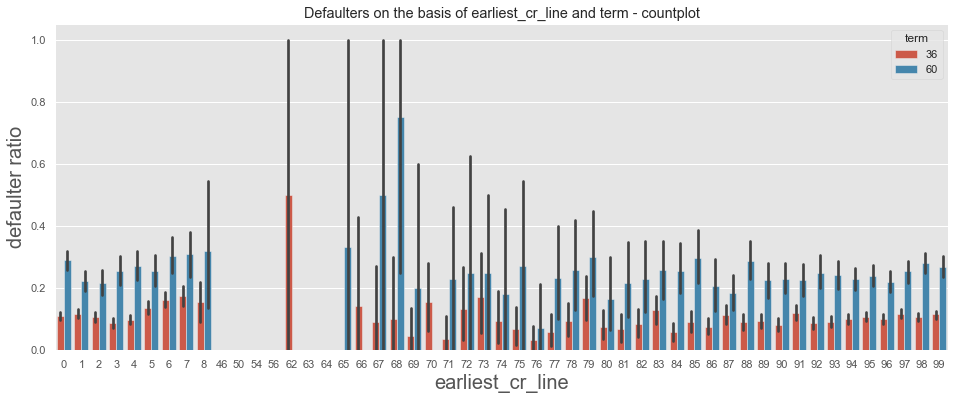

In [59]:
# check defaulters on the basis of earliest_cr_line and term

plotBarBivariateAnalysis("earliest_cr_line", "term")

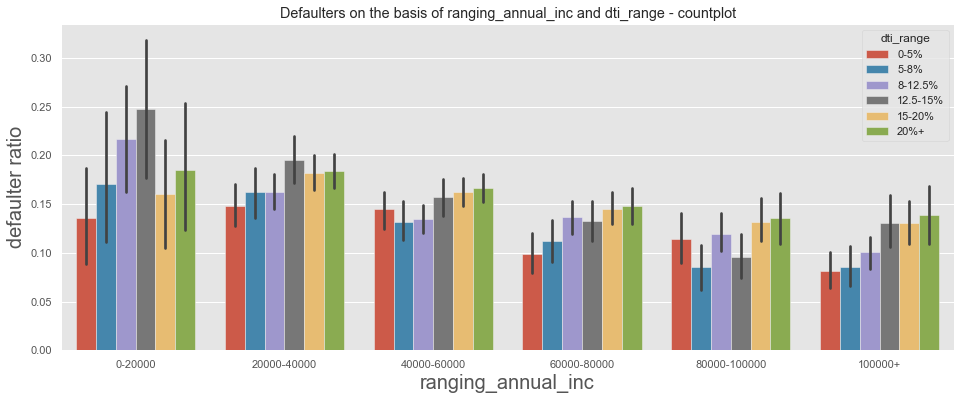

In [60]:
# check defaulters on the basis of annual_inc and dti

plotBarBivariateAnalysis("ranging_annual_inc", "dti_range")

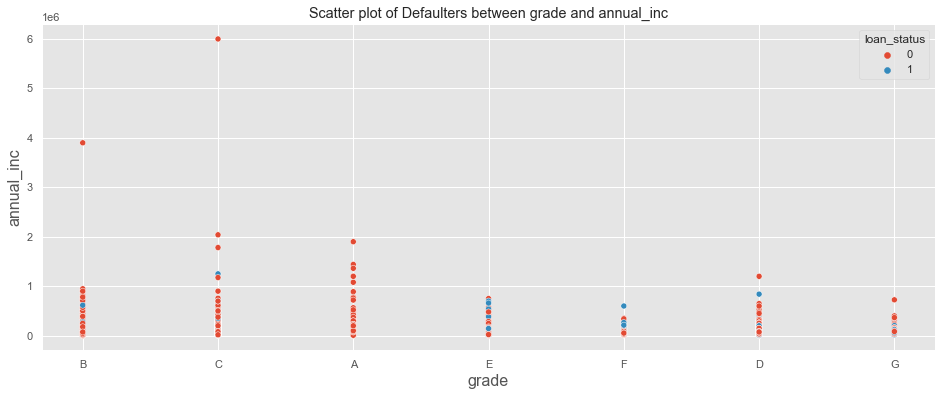

In [61]:
# check defaulters on the basis of annual_inc and grade

plotScatter("grade", "annual_inc")

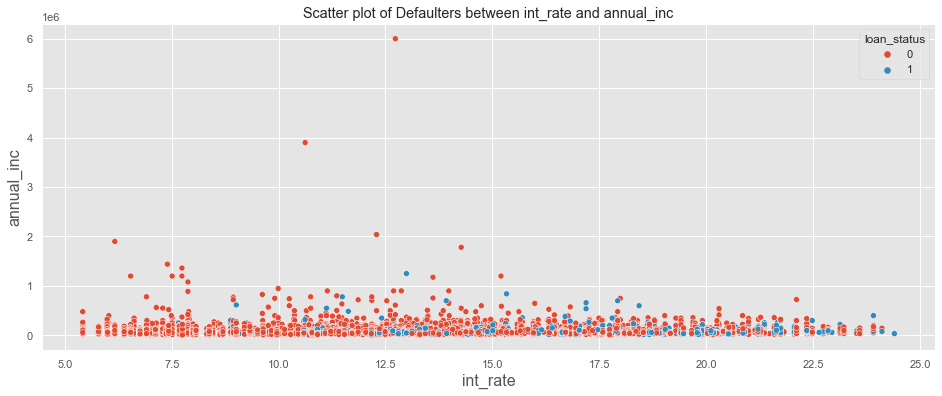

In [62]:
# check defaulters on the basis of int_rate and annual_inc

plotScatter("int_rate", "annual_inc")

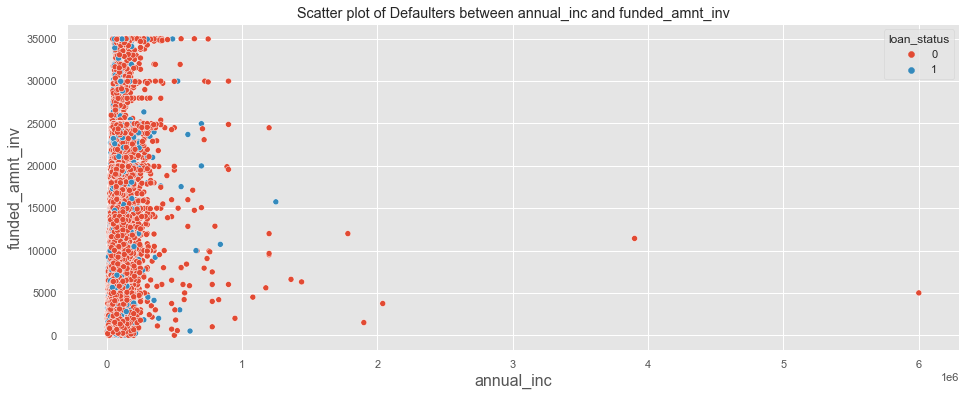

In [63]:
# check defaulters on the basis of annual_inc and funded_amnt_inv

plotScatter("annual_inc", "funded_amnt_inv")

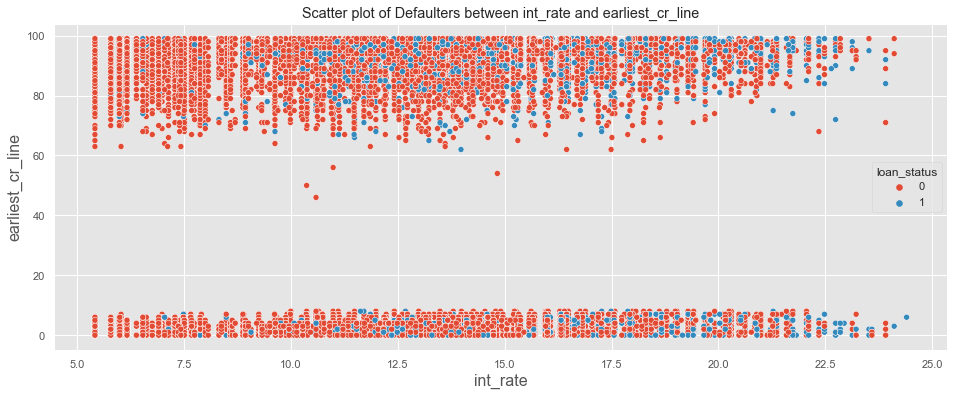

In [64]:
# check defaulters on the basis of earliest_cr_line and int_rate

plotScatter("int_rate", "earliest_cr_line")

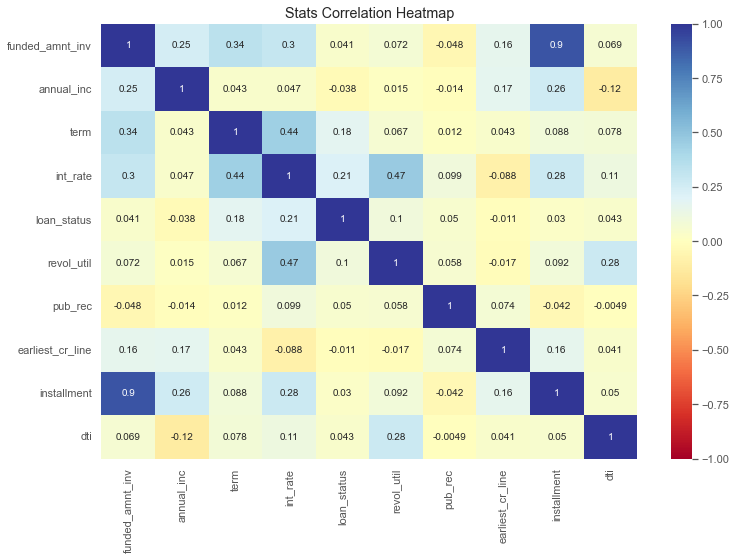

In [65]:
# multivariate analysis with correlating stats by plotting heat map
continuous_f = ["funded_amnt_inv", "annual_inc", "term", "int_rate", "loan_status", "revol_util", "pub_rec", "earliest_cr_line","installment","dti"]
loan_corr = loan[continuous_f].corr()
sns.heatmap(loan_corr,vmin=-1.0,vmax=1.0,annot=True, cmap="RdYlBu")
plt.title("Stats Correlation Heatmap")
plt.show()